# SETTINGS

This notebooks imports the processed data `orders.csv` and `items.csv` generated in `notebook_01_data_prep.ipynb`. 

The notebook performs the following operations:
- creating new item and order-related features 
- transforming order data in the format suitable for modeling
- exporting the resulting labeled and unlabeled data as `df.csv` and `df_test.csv`. 
 
The created features include:
- fine-grained item categories
- average customer ratings per category and manufacturer
- mean prices per category and manufacturer
- count and total amount of orders over previous time periods
- number of promotion days 
- days since the last order
- automatically extracted time series features using `tsfresh`

A detailed walkthrough of the code covering the key steps is provided in [this blog post](https://kozodoi.me/python/time%20series/demand%20forecasting/competitions/2020/07/27/demand-forecasting.html).

In [2]:
##### LIBRARIES
!pip install tsfresh
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats
from scipy.signal import find_peaks

import os
import time
import datetime
import random
import multiprocessing
import pickle
import warnings
import gc
from tqdm import tqdm
import sys

from tsfresh import extract_features

  Obtaining dependency information for tsfresh from https://files.pythonhosted.org/packages/62/72/cf614f4dc6fa0d16f6cbf9e97d464cfdf60eca7e051bcaa3f403572c007c/tsfresh-0.20.1-py2.py3-none-any.whl.metadata
  Obtaining dependency information for stumpy>=1.7.2 from https://files.pythonhosted.org/packages/c4/9d/9752261f8fe19ab4239caf1ba3864b04a0d7ab0033155cb11f86f124a642/stumpy-1.12.0-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.3/95.3 kB 671.1 kB/s eta 0:00:000:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.1/169.1 kB 1.2 MB/s eta 0:00:00a 0:00:01


In [3]:
##### MODULES

sys.path.append('../codes')  

from versioning import save_csv_version

In [4]:
##### SETTINGS

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
plt.style.use('dark_background')
%matplotlib inline
gc.enable()

# DATA IMPORT

In [5]:
# read data
orders = pd.read_csv('../data/prepared/orders_v1.csv', compression = 'gzip')
items  = pd.read_csv('../data/prepared/items_v1.csv',  compression = 'gzip')
print(orders.shape)
print(items.shape)

(2181955, 5)
(10463, 12)


In [6]:
# convert dates
orders['time']       = pd.to_datetime(orders['time'].astype('str'),       infer_datetime_format = True)
items['promotion_0'] = pd.to_datetime(items['promotion_0'].astype('str'), infer_datetime_format = True)
items['promotion_1'] = pd.to_datetime(items['promotion_1'].astype('str'), infer_datetime_format = True)
items['promotion_2'] = pd.to_datetime(items['promotion_2'].astype('str'), infer_datetime_format = True)

# ADD FEATURES: ITEMS

In [7]:
items.head()

,itemID,simulationPrice,brand,manufacturer,customerRating,category1,category2,category3,recommendedRetailPrice,promotion_0,promotion_1,promotion_2
0,1,3.43,NaN,1,4.38,1,1,1,8.84,NaT,NaT,NaT
1,2,9.15,NaN,2,3.00,1,2,1,16.92,NaT,NaT,NaT
2,3,14.04,NaN,3,5.00,1,3,1,15.89,NaT,NaT,NaT
3,4,14.10,NaN,2,4.44,1,2,1,40.17,NaT,NaT,NaT
4,5,7.48,NaN,2,2.33,1,1,1,17.04,NaT,NaT,NaT


In [8]:
# price ratio
items['recommended_simulation_price_ratio'] = items['simulationPrice'] / items['recommendedRetailPrice']
items['recommended_simulation_price_ratio'].describe()

count    10463.000000
mean         0.957107
std          0.616878
min          0.020094
25%          0.449184
50%          0.813378
75%          1.359211
max          5.678983
Name: recommended_simulation_price_ratio, dtype: float64

In [9]:
# detailed item category
items['category'] = items['category1'].astype(str) + items['category2'].astype(str) + items['category3'].astype(str)
items['category'] = items['category'].astype(int)
items['category'].nunique()

75

In [10]:
# customer rating ratio per manufacturer
rating_manufacturer = items.groupby('manufacturer')['customerRating'].agg('mean').reset_index()
rating_manufacturer.columns = ['manufacturer', 'mean_customerRating_manufacturer']
items = items.merge(rating_manufacturer, how = 'left', on = 'manufacturer')
items['customerRating_manufacturer_ratio'] = items['customerRating'] / items['mean_customerRating_manufacturer']
del items['mean_customerRating_manufacturer']
items['customerRating_manufacturer_ratio'].describe()

count    3346.000000
mean        1.000000
std         0.231363
min         0.211680
25%         0.944197
50%         1.060606
75%         1.136024
max         1.767617
Name: customerRating_manufacturer_ratio, dtype: float64

In [12]:
# customer rating ratio per category
rating_category = items.groupby('category')['customerRating'].agg('mean').reset_index()
rating_category.columns = ['category', 'mean_customerRating_category']
items = items.merge(rating_category, how = 'left', on = 'category')
items['customerRating_category_ratio'] = items['customerRating'] / items['mean_customerRating_category']
del items['mean_customerRating_category']
items['customerRating_category_ratio'].describe()

count    3346.000000
mean        1.000000
std         0.233089
min         0.211423
25%         0.927767
50%         1.098585
75%         1.125704
max         1.714286
Name: customerRating_category_ratio, dtype: float64

# ADD FEATURES: ORDERS

In [13]:
# total orders
print(orders['order'].sum())

2715559


In [14]:
##### AGGREGATE ORDERS BY DAY

# aggregation
orders['day_of_year'] = orders['time'].dt.dayofyear
orders_price = orders.groupby(['itemID', 'day_of_year'])['salesPrice'].agg('mean').reset_index()
orders = orders.groupby(['itemID', 'day_of_year'])['order'].agg('sum').reset_index()
orders.head()

,itemID,day_of_year,order
0,1,23,1
1,1,25,1
2,1,29,307
3,1,30,3
4,1,31,1


In [15]:
# check total orders
print(orders['order'].sum())

2715559


In [16]:
##### ADD MISSING INPUTS [ORDERS]

# add items that were never sold before
missing_itemIDs = set(items['itemID'].unique()) - set(orders['itemID'].unique())
missing_rows = pd.DataFrame({'itemID':     list(missing_itemIDs), 
                            'day_of_year': np.ones(len(missing_itemIDs)).astype('int'), 
                            'order':       np.zeros(len(missing_itemIDs)).astype('int')})
orders = pd.concat([orders, missing_rows], axis = 0)
print(orders.shape)

# add zeros for days with no transactions
agg_orders = orders.groupby(['itemID', 'day_of_year']).order.unique().unstack('day_of_year').stack('day_of_year', dropna = False)
agg_orders = agg_orders.reset_index()
agg_orders.columns = ['itemID', 'day_of_year', 'order']
agg_orders['order'].fillna(0, inplace = True)
agg_orders['order'] = agg_orders['order'].astype(int)
print(agg_orders.shape)

(100771, 3)
(1883340, 3)


In [17]:
##### ADD MISSING INPUTS [PRICES]

# add items that were never sold before
missing_rows = pd.DataFrame({'itemID':     list(missing_itemIDs), 
                            'day_of_year': np.ones(len(missing_itemIDs)).astype('int'), 
                            'salesPrice':  np.zeros(len(missing_itemIDs)).astype('int')})
orders_price = pd.concat([orders_price, missing_rows], axis = 0)
print(orders_price.shape)

# add zeros for days with no transactions
agg_orders_price = orders_price.groupby(['itemID', 'day_of_year']).salesPrice.unique().unstack('day_of_year').stack('day_of_year', dropna = False)
agg_orders_price = agg_orders_price.reset_index()
agg_orders_price.columns = ['itemID', 'day_of_year', 'salesPrice']
agg_orders_price['salesPrice'].fillna(0, inplace = True)
agg_orders_price['salesPrice'] = agg_orders_price['salesPrice'].astype(int)
agg_orders_price['salesPrice'][agg_orders_price['salesPrice'] == 0] = np.nan
print(agg_orders_price.shape)

# fill missing prices for dates with no orders
agg_orders_price['salesPrice'] = agg_orders_price.groupby(['itemID']).salesPrice.fillna(method = 'ffill')
agg_orders_price['salesPrice'] = agg_orders_price.groupby(['itemID']).salesPrice.fillna(method = 'bfill')
agg_orders_price = agg_orders_price.merge(items[['itemID', 'simulationPrice']], how = 'left', on = 'itemID')
agg_orders_price['salesPrice'][agg_orders_price['salesPrice'].isnull()] = agg_orders_price['simulationPrice'][agg_orders_price['salesPrice'].isnull()]
del agg_orders_price['simulationPrice']

# merge prices to orders
agg_orders = agg_orders.merge(agg_orders_price, how = 'left', on = ['itemID', 'day_of_year'])
print(agg_orders.shape)

(100771, 3)
(1883340, 3)
(1883340, 4)


In [18]:
##### FIND PROMOTION DAYS

# documentation says that we have to manually mark promotion days in the training period
# without marking, predictions are difficult because orders in some days explode without apparent reason
# we need to be very careful with threshold and rely on visual analysis and/or better metric to mark promos
# I started with treating promotions as days when the number of orders for a given item exceeds 90th percentile
# now I am trying to use a smarter technique using find_peaks() and specifying height and prominence

# computations
agg_orders['promotion'] = 0
for itemID in tqdm(agg_orders['itemID'].unique()):
    '''
    # using quantiles
    promo_quant = orders[orders['itemID'] == itemID]['order'].quantile(0.90)
    orders.loc[(orders['itemID'] == itemID) & (orders['order'] >= promo_quant), 'promotion'] = 1
    '''
    # using find_peaks
    promo    = np.zeros(len(agg_orders[agg_orders['itemID'] == itemID]))
    avg      = agg_orders[(agg_orders['itemID'] == itemID)]['order'].median()
    std      = agg_orders[(agg_orders['itemID'] == itemID)]['order'].std()
    peaks, _ = find_peaks(np.append(agg_orders[agg_orders['itemID'] == itemID]['order'].values, avg), # append avg to enable marking last point as promo
                          prominence = max(5, std),  # peak difference with neighbor points; max(5,std) to exclude cases when std is too small
                          height     = avg + 2*std)  # minimal height of a peak
    promo[peaks] = 1
    agg_orders.loc[agg_orders['itemID'] == itemID, 'promotion'] = promo
    
# check total promotions
print(agg_orders['promotion'].sum())

100%|████████████████████████████████████| 10463/10463 [00:46<00:00, 223.24it/s]

14911


In [20]:
##### COMPARE PROMOTIONS NUMBER

# computations
promo_in_train = (agg_orders['promotion'].sum() / agg_orders['day_of_year'].max()) / len(items)
promo_in_test  = (3*len(items) - items.promotion_0.isnull().sum() - items.promotion_2.isnull().sum() - items.promotion_1.isnull().sum()) / 14 / len(items)

# info
print('Daily p(promotion) per item in train: {}'.format(np.round(promo_in_train, 4)))
print('Daily p(promotion) per item in test:  {}'.format(np.round(promo_in_test , 4)))

Daily p(promotion) per item in train: 0.0079
Daily p(promotion) per item in test:  0.0141


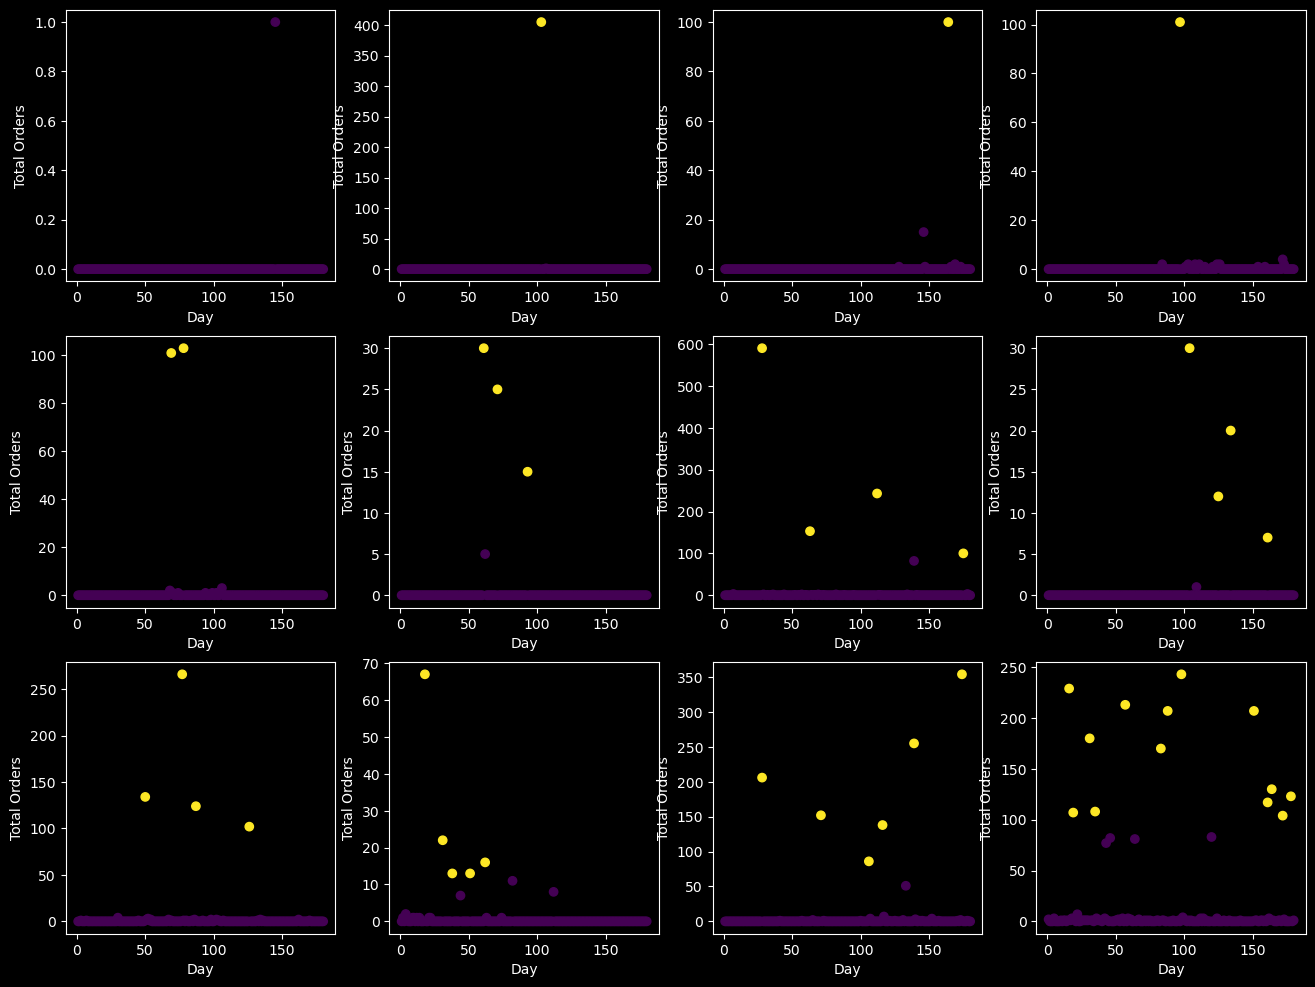

In [21]:
##### EXAMPLE SALES PLOT

# compute promo count
promo_count = agg_orders.groupby('itemID')['promotion'].agg('sum').reset_index()
promo_count = promo_count.sort_values('promotion').reset_index(drop = True)

# plot some items
item_plots = [0, 2000, 4000, 6000, 8000, 9000, 10000, 10100, 10200, 10300, 10400, 10462]
fig = plt.figure(figsize = (16, 12))
for i in range(len(item_plots)):
    plt.subplot(3, 4, i + 1)
    df = agg_orders[agg_orders.itemID == promo_count['itemID'][item_plots[i]]]
    plt.scatter(df['day_of_year'], df['order'], c = df['promotion'])
    plt.ylabel('Total Orders')
    plt.xlabel('Day')

In [24]:
##### COMPUTING TARGETS AND FEATURES

# parameters
days_input  = [1, 7, 14, 21, 28, 35]
days_target = 14

# preparations
day_first = np.max(days_input)
day_last  = agg_orders['day_of_year'].max() - days_target + 1
orders    = None

# merge manufacturer and category
agg_orders = agg_orders.merge(items[['itemID', 'manufacturer']], how = 'left')
agg_orders = agg_orders.merge(items[['itemID', 'category']],     how = 'left')


# computations
for day_of_year in tqdm(list(range(149, day_last)) + [agg_orders['day_of_year'].max()]):
                

    ### VALIDAION: TARGET, PROMOTIONS, PRICES
        
    # day intervals
    target_day_min = day_of_year + 1
    target_day_max = day_of_year + days_target
    
    # compute target and promo: labeled data
    if day_of_year < agg_orders['day_of_year'].max():
        
        # target and future promo
        tmp_df = agg_orders[(agg_orders['day_of_year'] >= target_day_min) &
                    (agg_orders['day_of_year'] <= target_day_max)
                   ].groupby('itemID')[['order', 'promotion']].agg('sum').reset_index()
        tmp_df.columns = ['itemID', 'target', 'promo_in_test']
        
        # future price
        tmp_df['mean_price_test'] = agg_orders[(agg_orders['day_of_year'] >= target_day_min) &
                                               (agg_orders['day_of_year'] <= target_day_max)
                                              ].groupby('itemID')['salesPrice'].agg('mean').reset_index()['salesPrice']
        
        # merge manufacturer and category
        tmp_df = tmp_df.merge(items[['itemID', 'manufacturer', 'category']], how = 'left', on = 'itemID')
        
        # future price per manufacturer
        tmp_df_manufacturer = agg_orders[(agg_orders['day_of_year'] >= target_day_min) &
                                         (agg_orders['day_of_year'] <= target_day_max)
                                         ].groupby('manufacturer')['salesPrice'].agg('mean').reset_index()
        tmp_df_manufacturer.columns = ['manufacturer', 'mean_price_test_manufacturer']
        tmp_df = tmp_df.merge(tmp_df_manufacturer, how = 'left', on = 'manufacturer')
        
        # future price per category
        tmp_df_category = agg_orders[(agg_orders['day_of_year'] >= target_day_min) &
                                     (agg_orders['day_of_year'] <= target_day_max)
                                     ].groupby('category')['salesPrice'].agg('mean').reset_index()
        tmp_df_category.columns = ['category', 'mean_price_test_category']
        tmp_df = tmp_df.merge(tmp_df_category, how = 'left', on = 'category')
        
        # future promo per manufacturer
        tmp_df_manufacturer = agg_orders[(agg_orders['day_of_year'] >= target_day_min) &
                                         (agg_orders['day_of_year'] <= target_day_max)
                                         ].groupby('manufacturer')['promotion'].agg('sum').reset_index()
        tmp_df_manufacturer.columns = ['manufacturer', 'promo_in_test_manufacturer']
        tmp_df = tmp_df.merge(tmp_df_manufacturer, how = 'left', on = 'manufacturer')

        # future promo per category
        tmp_df_category = agg_orders[(agg_orders['day_of_year'] >= target_day_min) &
                                     (agg_orders['day_of_year'] <= target_day_max)
                                     ].groupby('category')['promotion'].agg('sum').reset_index()
        tmp_df_category.columns = ['category', 'promo_in_test_category']
        tmp_df = tmp_df.merge(tmp_df_category, how = 'left', on = 'category')
                       
        
    # compute target and promo: unlabeled data
    else:
        
        # placeholders
        tmp_df = pd.DataFrame({'itemID':                     items.itemID,
                               'target':                     np.nan,
                               'promo_in_test':              np.nan,
                               'mean_price_test':            items.simulationPrice,
                               'manufacturer':               items.manufacturer,
                               'category':                   items.category,
                               'promo_in_test_manufacturer': np.nan,
                               'promo_in_test_category':     np.nan})

        
    ### TRAINING: LAG-BASED FEATURES
            
    # compute features
    for day_input in days_input:
        
        # day intervals
        input_day_min  = day_of_year - day_input + 1
        input_day_max  = day_of_year
    
        # frequency, promo and price
        tmp_df_input = agg_orders[(agg_orders['day_of_year'] >= input_day_min) &
                                  (agg_orders['day_of_year'] <= input_day_max)
                                 ].groupby('itemID')
        tmp_df['order_sum_last_'   + str(day_input)] = tmp_df_input['order'].agg('sum').reset_index()['order']
        tmp_df['order_count_last_' + str(day_input)] = tmp_df_input['order'].agg(lambda x: len(x[x > 0])).reset_index()['order']
        tmp_df['promo_count_last_' + str(day_input)] = tmp_df_input['promotion'].agg('sum').reset_index()['promotion']
        tmp_df['mean_price_last_'  + str(day_input)] = tmp_df_input['salesPrice'].agg('mean').reset_index()['salesPrice']

        # frequency, promo per manufacturer
        tmp_df_input = agg_orders[(agg_orders['day_of_year'] >= input_day_min) &
                                  (agg_orders['day_of_year'] <= input_day_max)
                                 ].groupby('manufacturer')
        tmp_df_manufacturer = tmp_df_input['order'].agg('sum').reset_index()
        tmp_df_manufacturer.columns = ['manufacturer', 'order_manufacturer_sum_last_' + str(day_input)]
        tmp_df_manufacturer['order_manufacturer_count_last_' + str(day_input)] = tmp_df_input['order'].agg(lambda x: len(x[x > 0])).reset_index()['order']
        tmp_df_manufacturer['promo_manufacturer_count_last_' + str(day_input)] = tmp_df_input['promotion'].agg('sum').reset_index()['promotion']
        tmp_df = tmp_df.merge(tmp_df_manufacturer, how = 'left', on = 'manufacturer')
    
        # frequency, promo per category
        tmp_df_input = agg_orders[(agg_orders['day_of_year'] >= input_day_min) &
                                  (agg_orders['day_of_year'] <= input_day_max)
                                 ].groupby('category')
        tmp_df_category = tmp_df_input['order'].agg('sum').reset_index()
        tmp_df_category.columns = ['category', 'order_category_sum_last_' + str(day_input)]       
        tmp_df_category['order_category_count_last_' + str(day_input)] = tmp_df_input['order'].agg(lambda x: len(x[x > 0])).reset_index()['order']
        tmp_df_category['promo_category_count_last_' + str(day_input)] = tmp_df_input['promotion'].agg('sum').reset_index()['promotion']
        tmp_df = tmp_df.merge(tmp_df_category, how = 'left', on = 'category')

        # frequency, promo per all items
        tmp_df_input = agg_orders[(agg_orders['day_of_year'] >= input_day_min) &
                                  (agg_orders['day_of_year'] <= input_day_max)]
        tmp_df['order_all_sum_last_'   + str(day_input)] = tmp_df_input['order'].agg('sum')
        tmp_df['order_all_count_last_' + str(day_input)] = tmp_df_input['order'].agg(lambda x: len(x[x > 0]))
        tmp_df['promo_all_count_last_' + str(day_input)] = tmp_df_input['promotion'].agg('sum')
        
        # recency
        if day_input == max(days_input):
            tmp_df_input = agg_orders[(agg_orders['day_of_year'] >= input_day_min) &
                                      (agg_orders['day_of_year'] <= input_day_max) &
                                      (agg_orders['order'] > 0)
                                     ].groupby('itemID')
            tmp_df['days_since_last_order'] = (day_of_year - tmp_df_input['day_of_year'].agg('max')).reindex(tmp_df.itemID).reset_index()['day_of_year']
            tmp_df['days_since_last_order'].fillna(day_input, inplace = True)
            
            
        # tsfresh features
        if day_input == max(days_input):
            tmp_df_input = agg_orders[(agg_orders['day_of_year'] >= input_day_min) &
                                      (agg_orders['day_of_year'] <= input_day_max)]
            tmp_df_input = tmp_df_input[['day_of_year', 'itemID', 'order']]
            extracted_features = extract_features(tmp_df_input, column_id = 'itemID', column_sort = 'day_of_year')
            extracted_features['itemID'] = extracted_features.index
            tmp_df = tmp_df.merge(extracted_features, how = 'left', on = 'itemID')
            
            
    ### FINAL PREPARATIONS
            
    # add day of year
    tmp_df.insert(1, column = 'day_of_year', value = day_of_year)
        
    # merge data
    orders = pd.concat([orders, tmp_df], axis = 0)
    
    # drop manufacturer and category
    del orders['manufacturer']
    del orders['category']

Feature Extraction:  35%|████████▍               | 7/20 [00:16<00:22,  1.70s/it]


Feature Extraction:  80%|██████████████████▍    | 16/20 [00:32<00:05,  1.30s/it]


Feature Extraction:  15%|███▌                    | 3/20 [00:08<00:35,  2.09s/it]


Feature Extraction:  60%|█████████████▊         | 12/20 [00:22<00:09,  1.16s/it]


100%|███████████████████████████████████████████| 19/19 [15:42<00:00, 49.60s/it]


In [25]:
##### REMOVE MISSINGS

good_nas = ['target', 
            'mean_price_test_category', 'mean_price_test_manufacturer',
            'promo_in_test', 'promo_in_test_category', 'promo_in_test_manufacturer']
nonas = list(orders.columns[orders.isnull().sum() == 0]) + good_nas
orders = orders[nonas]
print(orders.shape)

(198797, 470)


In [26]:
##### COMPUTE MEAN PRICE RATIOS

print(orders.shape)
price_vars = ['mean_price_last_1', 'mean_price_last_7', 'mean_price_last_14', 
              'mean_price_last_21', 'mean_price_last_28', 'mean_price_last_35']
for var in price_vars:
    orders['ratio_'              + str(var)] = orders['mean_price_test']              / orders[var]
    orders['ratio_manufacturer_' + str(var)] = orders['mean_price_test_manufacturer'] / orders[var]
    orders['ratio_category_'     + str(var)] = orders['mean_price_test_category']     / orders[var]
print(orders.shape)

(198797, 470)
(198797, 488)


Text(0.5, 0, 'Day')

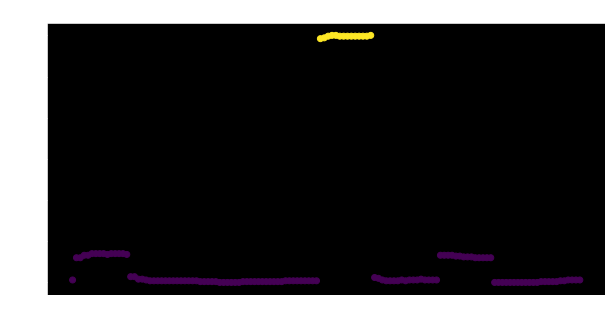

In [32]:
##### EXAMPLE SALES PLOT

df = orders[orders.itemID == 1]
plt.figure(figsize = (10, 5))
plt.scatter(df['day_of_year'], df['target'], c = df['promo_in_test'])
plt.title('itemID == 1')
plt.ylabel('Target (orders in next 14 days)')
plt.xlabel('Day')

# MERGE DATA SETS

In [27]:
print(orders.shape)
print(items.shape)
df = pd.merge(orders, items, on = 'itemID', how = 'left')
print(df.shape)

(198797, 488)
(10463, 16)
(198797, 503)


# EXTRACT TEST DATA

In [29]:
# partition intro train and test
df_train = df[df['day_of_year'] <  df['day_of_year'].max()]
df_test  = df[df['day_of_year'] == df['day_of_year'].max()]
print(df_train.shape)
print(df_test.shape)

(188334, 503)
(10463, 503)


In [30]:
##### COMPUTE FEATURES FOR TEST DATA

# add promotion info to test
promo_vars = df_test.filter(like = 'promotion_').columns
df_test['promo_in_test'] = 3 - df_test[promo_vars].isnull().sum(axis = 1)
df_test['promo_in_test'].describe()


### PROMO PER MANUFACTURER, CATEGORY

del df_test['promo_in_test_manufacturer'], df_test['promo_in_test_category']

# future promo per manufacturer
tmp_df_manufacturer = df_test.groupby('manufacturer')['promo_in_test'].agg('sum').reset_index()
tmp_df_manufacturer.columns = ['manufacturer', 'promo_in_test_manufacturer']
df_test = df_test.merge(tmp_df_manufacturer, how = 'left', on = 'manufacturer')
print(df_test.shape)

# future promo per category
tmp_df_category = df_test.groupby('category')['promo_in_test'].agg('sum').reset_index()
tmp_df_category.columns = ['category', 'promo_in_test_category']
df_test = df_test.merge(tmp_df_category, how = 'left', on = 'category')
print(df_test.shape)


### PRICE PER MANUFACTURER, CATEGORY

del df_test['mean_price_test_manufacturer'], df_test['mean_price_test_category']

# future price per manufacturer
tmp_df_manufacturer = df_test.groupby('manufacturer')['mean_price_test'].agg('mean').reset_index()
tmp_df_manufacturer.columns = ['manufacturer', 'mean_price_test_manufacturer']
df_test = df_test.merge(tmp_df_manufacturer, how = 'left', on = 'manufacturer')
print(df_test.shape)

# future price per category
tmp_df_category = df_test.groupby('category')['mean_price_test'].agg('mean').reset_index()
tmp_df_category.columns = ['category', 'mean_price_test_category']
df_test = df_test.merge(tmp_df_category, how = 'left', on = 'category')
print(df_test.shape)


### MEAN PRICE RATIOS

for var in price_vars:
    df_test['ratio_'              + str(var)] = df_test['mean_price_test']              / df_test[var]
    df_test['ratio_manufacturer_' + str(var)] = df_test['mean_price_test_manufacturer'] / df_test[var]
    df_test['ratio_category_'     + str(var)] = df_test['mean_price_test_category']     / df_test[var]
print(df_test.shape)

(10463, 502)
(10463, 503)
(10463, 502)
(10463, 503)
(10463, 503)


In [31]:
# drop promotion dates
df_test.drop(promo_vars,  axis = 1, inplace = True)
df_train.drop(promo_vars, axis = 1, inplace = True)
print(df_train.shape)
print(df_test.shape)

# drop mean prices
price_vars = price_vars + ['mean_price_test_manufacturer', 'mean_price_test_category']
df_test.drop(price_vars,  axis = 1, inplace = True)
df_train.drop(price_vars, axis = 1, inplace = True)
print(df_train.shape)
print(df_test.shape)

(188334, 500)
(10463, 500)
(188334, 492)
(10463, 492)


# EXPORT

In [32]:
# save data frame
# save_csv_version() automatically adds version number to prevent overwriting
save_csv_version('../data/prepared/df.csv',      df_train, index = False, compression = 'gzip')
save_csv_version('../data/prepared/df_test.csv', df_test,  index = False, compression = 'gzip', min_version = 3)
print(df_train.shape)
print(df_test.shape)

Saved as ../data/prepared/df_v1.csv
Saved as ../data/prepared/df_test_v3.csv
(188334, 492)
(10463, 492)
